# Is Clenshaw-Curtis Quadrature Better than Gaussian Quadrature?

In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
from scipy.fftpack import ifft
from numpy.polynomial.legendre import leggauss
eps = np.finfo(float).eps

In [2]:
def clencurt(n1):
    n = n1 - 1
    C = np.zeros((n1,2))
    k = 2*(1+np.arange(np.floor(n/2)))
    # Compute weights --> integral of Tn(x)
    C[::2,0] = 2/np.hstack((1, 1-k*k))
    C[1,1] = -n
    V = np.vstack((C,np.flipud(C[1:n,:])))
    # Real part of inverse FFT ~ Cosine transform
    F = np.real(ifft(V, n=None, axis=0))
    x = F[:n1,1]
    w = np.hstack((F[0,0],2*F[1:n,0],F[n,0]))
    return x, w

In [3]:
def transint(x,w,a,b):
    x = (b-a)*(x + (a+b)/(b-a))/2
    w = (b-a)*w/2
    return x, w

In [4]:
def mygauss(N, func, a = -1, b = 1):
    x, w = leggauss(N)
    x, w = transint(x,w,a,b)
    return w.dot(func(x))

In [5]:
def myclencurt(N, func, a = -1, b = 1):
    x, w = clencurt(N)
    x, w = transint(x,w,a,b)
    return w.dot(func(x))

### Test Clenshaw-Curtis versus Gaussian Quadrature

###### Which method is computationally more efficient?

In [6]:
# This cell will take a while to run so please be patient.
%timeit -n 100 [clencurt(N) for N in range(4,180,16)]
%timeit -n 100 [leggauss(N) for N in range(4,180,16)]

875 µs ± 260 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.3 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


###### Which method is significantly (orders of magnitude) more accurate?

###### Answer, AFTER running through the three tasks below, which quadrature rule is better? When answering, compare the accuracy (error plots below) versus the computational cost you determined above.

###### The integral functions are defined:
* (Monomial) $$p(x) = x^{20}$$
* (Error Function) $$\mathrm{erf}(x) = \frac2{\sqrt{\pi}}\int^x_0e^{-t^2}\,dt$$
* (Fresnel Sine Integral) $$S(x) = \int^x_0 \sin(\frac\pi2 t^2)\,dt$$

Note that you are estimating:
* $$\int^1_{-1} x^{20}\,dx$$
* $$\mathrm{erf}(1) = \frac2{\sqrt{\pi}}\int^1_0e^{-t^2}\,dt$$
* $$S(1) = \int^1_0 \sin(\frac\pi2 t^2)\,dt$$

###### CC Versus GQ on Monomial

In [7]:
def p(x):
    return x**20

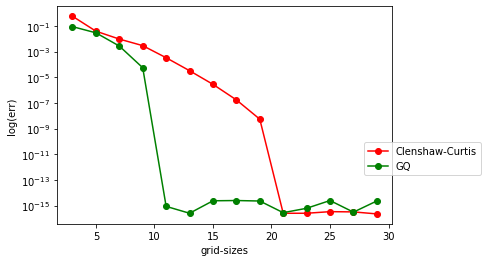

In [8]:
errc = []
errg = []
test = 2/21
nvec = np.arange(3,30,2)
#Construct a vector of errors and display them for the increasing grid-sizes
for n in nvec:
    # FILL IN FUNCTION CALLS AND QUADRATURE EVALUATIONS (DOT PRODUCTS)
    Icc = myclencurt(n,p)
    Igauss = mygauss(n,p)
    errc.append(np.fabs(Icc-test)+eps)
    errg.append(np.fabs(Igauss-test)+eps)
plt.semilogy(nvec,errc,'ro-',nvec,errg,'go-')
plt.legend(['Clenshaw-Curtis','GQ'],loc='center left',bbox_to_anchor=(0.9,0.3))
plt.xlabel('grid-sizes')
plt.ylabel('log(err)');

###### CC Versus GQ on Error Function

In [9]:
def erf(x):
    return 2*np.exp(-x**2)/np.sqrt(np.pi)

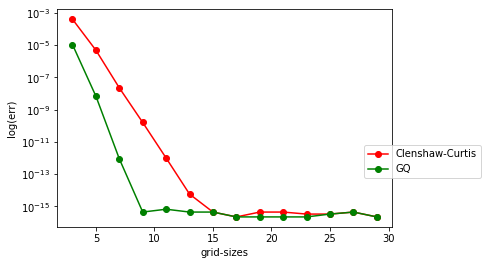

In [10]:
errc = []
errg = []
a = 0; b = 1;
test = sp.erf(1)
nvec = np.arange(3,30,2)
#Construct a vector of errors and display them for the increasing grid-sizes
for n in nvec:
    # FILL IN FUNCTION CALLS AND QUADRATURE EVALUATIONS (DOT PRODUCTS)
    Icc = myclencurt(n,erf,a,b)
    Igauss = mygauss(n,erf,a,b)
    errc.append(np.fabs(Icc-test)+eps)
    errg.append(np.fabs(Igauss-test)+eps)
plt.semilogy(nvec,errc,'ro-',nvec,errg,'go-')
plt.legend(['Clenshaw-Curtis','GQ'],loc='center left',bbox_to_anchor=(0.9,0.3))
plt.xlabel('grid-sizes')
plt.ylabel('log(err)');

###### CC Versus GQ on Fresnel Sine Function

In [11]:
def fress(x):
    return np.sin(np.pi*x**2/2)

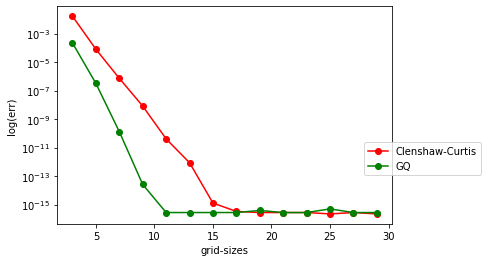

In [12]:
errc = []
errg = []
a = 0; b = 1;
test = sp.fresnel(1)[0]
nvec = np.arange(3,30,2)
#Construct a vector of errors and display them for the increasing grid-sizes
for n in nvec:
    # FILL IN FUNCTION CALLS AND QUADRATURE EVALUATIONS
    Icc = myclencurt(n,fress,a,b)
    Igauss = mygauss(n,fress,a,b)
    errc.append(np.fabs(Icc-test)+eps)
    errg.append(np.fabs(Igauss-test)+eps)
plt.semilogy(nvec,errc,'ro-',nvec,errg,'go-')
plt.legend(['Clenshaw-Curtis','GQ'],loc='center left',bbox_to_anchor=(0.9,0.3))
plt.xlabel('grid-sizes')
plt.ylabel('log(err)');

### Interesting Application

###### The height of a population is normally distributed with an average height ($\mu$) of 170 cm and a standard deviation ($\sigma$) of 5 cm. The probability (percentage that a sample falls with a given range) is given by $$P(t<x:\mu,\sigma) = \frac1{\sqrt{2\pi\sigma^2}}\int_0^xe^{-\frac{t^2}{2\sigma^2}}\,dt.$$

###### What percentage of the population falls below 175 cm?

###### What height is at the 90th percentile? That is, at what height does 90% of the population below?

In [33]:
def f(x):
    return np.exp((-(x-170)**2)/(2*5**2))

In [60]:
def fp(x):
    return 1/np.sqrt(2*np.pi*5**2)*np.exp(-(x-170)**2/(2*5**2))

In [61]:
# Compute the population percentage and print it out
avgheight = 170 #cm
stdDev = 5 #cm 
n = 50
a = 0
b = 175
cc = myclencurt(n,f,a,b)/np.sqrt(2*np.pi*(5**2))
gauss = mygauss(n,f,a,b)/np.sqrt(2*np.pi*(5**2))
print(cc)
print(gauss)


0.8413447462120317
0.8413447460685589


In [62]:
# Compute the height and print it out

In [63]:
x = 170
MAXITS = 30
tol = 1e-5
k = 0
err = 1
unn = []

while err > tol and k < MAXITS:
    eta = (mygauss(50,f, 0, x)/np.sqrt(2*np.pi*5**2)-0.9)/fp(x)
    x = x - eta
    err = np.fabs(eta)
    unn.append(err)
    k +=1
    
print(x)
print(err)
print(k)

176.40775782772232
2.6865377443703014e-06
5
